In [1]:
"""This DDPG algorithm on MountainCarContinuous problem is implemented by Yinyu Jin, inspired by https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b"""

"""Define OUNoise class and Memory class """ 

import numpy as np
import gym
from collections import deque
import random

# Ornstein-Ulhenbeck Process
# Taken from #https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
class OUNoise(object):
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.25, min_sigma=0.25, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
        
    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu
        
    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state
    
    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high)
       

class Memory:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)
    
    def push(self, state, action, reward, next_state, done):
        experience = (state, action, np.array([reward]), next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []

        batch = random.sample(self.buffer, batch_size)

        for experience in batch:
            state, action, reward, next_state, done = experience
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def __len__(self):
        return len(self.buffer)


In [2]:
"""Define Actor and Critic network"""

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 

class Actor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, state):
        """
        Param state is a torch tensor
        """
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))

        return x
    
    
class Critic(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, state, action):
        """
        Params state and actions are torch tensors
        """
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)

        return x


In [3]:
"""Define DDPGagent"""

class DDPGagent:
    def __init__(self, env, hidden_size=256, actor_learning_rate=1e-4, critic_learning_rate=1e-3, gamma=0.99, tau=5e-3, max_memory_size=50000):
        # Params
        self.num_states = env.observation_space.shape[0]
        self.num_actions = env.action_space.shape[0]
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.actor         = Actor (self.num_states,                    hidden_size, self.num_actions)
        self.actor_target  = Actor (self.num_states,                    hidden_size, self.num_actions)
        self.critic        = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)
        self.critic_target = Critic(self.num_states + self.num_actions, hidden_size, self.num_actions)

        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        
        # Training
        self.memory = Memory(max_memory_size)        
        self.critic_loss  = nn.MSELoss()
        self.actor_optimizer  = optim.Adam(self.actor.parameters(), lr=actor_learning_rate)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_learning_rate)
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        action = self.actor.forward(state)
        action = action.detach().numpy()[0,0]
        return action
    
    def update(self, batch_size):
        states, actions, rewards, next_states, _ = self.memory.sample(batch_size)
        states      = torch.FloatTensor(states)
        actions     = torch.FloatTensor(actions)
        rewards     = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
    
        # Critic loss        
        Qvals = self.critic.forward(states, actions)
        next_actions = self.actor_target.forward(next_states)
        next_Q = self.critic_target.forward(next_states, next_actions.detach())
        Qprime = rewards + self.gamma * next_Q
        critic_loss = self.critic_loss(Qvals, Qprime)

        # Actor loss
        policy_loss = -self.critic.forward(states, self.actor.forward(states)).mean()
        
        # update networks
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()

        self.critic_optimizer.zero_grad()
        critic_loss.backward() 
        self.critic_optimizer.step()

        # update target networks 
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))
       
        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * self.tau + target_param.data * (1.0 - self.tau))

def plot (episode, rewards, avg_rewards, steps):
    clear_output(True)
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(rewards)
    plt.plot(avg_rewards)
    plt.title('episode %s. reward: %s' % (episode, avg_rewards[-1]), fontsize=20)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.subplot(122)
    plt.title('episode %s. steps: %s' % (episode, np.mean(steps[-10:])))
    plt.xlabel('Episode')
    plt.ylabel('steps')
    plt.plot(steps)
    plt.savefig(f"DDPG.jpg", dpi=600)
    plt.show()            

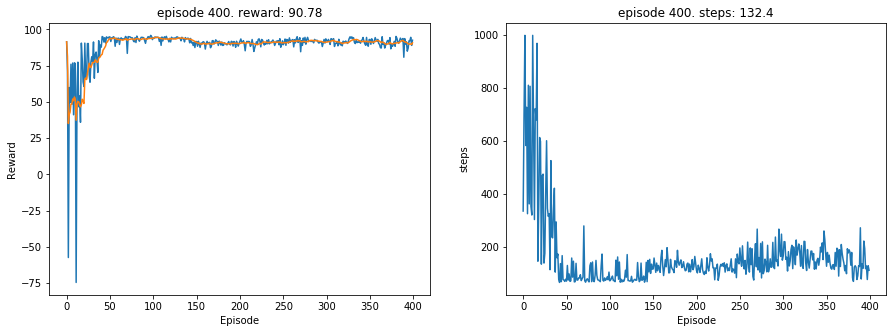

In [4]:
"""Run Main """

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# avoid the warning message
gym.logger.set_level(40)

env = gym.make("MountainCarContinuous-v0")

agent = DDPGagent(env)
noise = OUNoise(env.action_space)
batch_size = 256
rewards = []
avg_rewards = []
steps = []

for episode in range(1,401):
    state = env.reset()
    noise.reset()
    episode_reward = 0
    
    for step in range(2000):
        action = agent.get_action(state)
        action = noise.get_action(action, step)
        new_state, reward, done, _ = env.step(action) 
        agent.memory.push(state, action, reward, new_state, done)
        
        if len(agent.memory) > batch_size:
            agent.update(batch_size)        
        
        state = new_state
        episode_reward += reward
        
        # show performance 
        if episode == 400:
            env.render()

        if done:
            break

    # logging 
    rewards.append(episode_reward)
    avg_rewards.append(np.round(np.mean(rewards[-10:]), decimals=2))
    steps.append(step)
    
    if episode % 5 == 0:
        plot(episode, rewards, avg_rewards, steps)
    env.close()
